# Review
Hi, my name is Dmitry and I will be reviewing your project.

You can find my comments in colored markdown cells:

<div class="alert alert-success">
    If everything is done succesfully.
</div>

<div class="alert alert-info">
    If I have some (optional) suggestions, or questions to think about, or general comments.
</div>

<div class="alert alert-danger">
    If a section requires some corrections. Work can't be accepted with red comments.
</div>

First of all, thank you for turning in the project! While there is room for improvement, on the whole your project is looking pretty good. There are a couple of problems that need to be fixed, but don't worry! You've got this!

>Hi! Great, thanks!

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import random
random_state=42
random.seed(random_state)
np.random.seed(random_state)

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

<div class="markdown markdown_size_normal markdown_type_theory"><h1>Project description</h1><div class="paragraph">The data is stored in three files:</div><ul><li><code class="code-inline code-inline_theme_light">gold_recovery_train.csv</code> — training dataset d<a href="https://code.s3.yandex.net/datasets/gold_recovery_train.csv">ownload</a></li><li><code class="code-inline code-inline_theme_light">gold_recovery_test.csv</code> — test dataset <a href="https://code.s3.yandex.net/datasets/gold_recovery_test.csv">download</a></li><li><code class="code-inline code-inline_theme_light">gold_recovery_full.csv</code> — source dataset <a href="https://code.s3.yandex.net/datasets/gold_recovery_full.csv">download</a></li></ul><div class="paragraph">Data is indexed with the date and time of acquisition (<code class="code-inline code-inline_theme_light">date</code> feature). Parameters that are next to each other in terms of time are often similar.</div><div class="paragraph">Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.</div><div class="paragraph">The source dataset contains the training and test sets with all the features.</div><div class="paragraph">You have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data. For that, use our instructions.</div>

<h2>Data description</h2><div class="paragraph"><strong>Technological process</strong></div><ul><li><em>Rougher feed</em> — raw material</li><li><em>Rougher additions</em> (or <em>reagent additions</em>) — flotation reagents: <em>Xanthate, Sulphate, Depressant</em>
  <ul><li><em>Xanthate</em> — promoter or flotation activator;</li><li><em>Sulphate</em> — sodium sulphide for this particular process;</li><li><em>Depressant</em> — sodium silicate.</li></ul></li><li><em>Rougher process</em>  — flotation</li><li><em>Rougher tails</em> — product residues</li><li><em>Float banks</em> — flotation unit</li><li><em>Cleaner process</em> — purification</li><li><em>Rougher Au</em> — rougher gold concentrate</li><li><em>Final Au</em> — final gold concentrate</li></ul><div class="paragraph"><strong>Parameters of stages</strong></div><ul><li><em>air amount — volume of air</em></li><li><em>fluid levels</em></li><li><em>feed size</em> — feed particle size</li><li><em>feed rate</em></li></ul><h2>Feature naming</h2><div class="paragraph">Here's how you name the features:</div><div class="paragraph"><code class="code-inline code-inline_theme_light">[stage].[parameter_type].[parameter_name]</code></div><div class="paragraph">Example: <code class="code-inline code-inline_theme_light">rougher.input.feed_ag</code></div><div class="paragraph">Possible values for <code class="code-inline code-inline_theme_light">[stage]</code>:</div><ul><li><em>rougher —</em> flotation</li><li><em>primary_cleaner</em> — primary purification</li><li><em>secondary_cleaner</em> — secondary purification</li><li><em>final</em> — final characteristics</li></ul><div class="paragraph">Possible values for <code class="code-inline code-inline_theme_light">[parameter_type]</code>:</div><ul><li><em>input</em> — raw material parameters</li><li><em>output</em> — product parameters</li><li><em>state</em> — parameters characterizing the current state of the stage</li><li><em>calculation —</em> calculation characteristics</li></ul>

In [3]:
def display_group_density_plot(df, groupby, on, palette = None, figsize = None, title="", ax=None): 
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """
    if palette is None:
      palette = sns.color_palette('Set2')
    if figsize is None:
      figsize = (10, 5)
    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    if ax is None:
      fig = plt.figure(figsize=figsize)
      ax = fig.add_subplot(111)
    
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value, ax=ax)
    if not title:
      title = str("Distribution of " + on + " per " + groupby + " group")
    
    ax.set_title(title,fontsize=16)
    ax.set_xlabel(on, fontsize=16)
    return ax 

In [4]:
#missing value ratio
def missing_values(df):
    df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
    df_nulls.columns = ["type","count","missing_ratio"]
    df_nulls=df_nulls[df_nulls["count"]>0]
    df_nulls.sort_values(by="missing_ratio", ascending=False)
    return df_nulls

#outliers by 3 sigma rule
def outlier(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return len(outliers)

# full description statistics 
def describe_full(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    data_describe['outliers']=[outlier(df_numeric[col]) for col in df_numeric.columns]
    data_describe['kurtosis']=df_numeric.kurtosis()
    return data_describe

1. Prepare the data

1.1. Open the files and look into the data.
Path to files:
* /datasets/gold_recovery_train.csv
* /datasets/gold_recovery_test.csv
* /datasets/gold_recovery_full.csv

In [5]:
df_train = pd.read_csv("https://code.s3.yandex.net/datasets/gold_recovery_train.csv")
df_test = pd.read_csv("https://code.s3.yandex.net/datasets/gold_recovery_test.csv")
df_full = pd.read_csv("https://code.s3.yandex.net/datasets/gold_recovery_full.csv")

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

In [7]:
list(filter(lambda s:"rougher" in s,df_train.columns))

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_l

In [8]:
rougher_output_recovery_calc = 100 * (df_train['rougher.output.concentrate_au'] * (df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au'])) / (df_train['rougher.input.feed_au'] * (df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au']))
df_output_rougher = pd.DataFrame({"output_recovery":df_train["rougher.output.recovery"],"calc":rougher_output_recovery_calc}).dropna()
MAE = mean_absolute_error(df_output_rougher["output_recovery"],df_output_rougher["calc"])
print(f"MAE={MAE}")
del df_output_rougher

MAE=1.0898633667227423e-14


as we could see, result is correct

<div class="alert alert-success">
    Good job checking the recovery data validity!
</div>

1.3. Analyze the features not available in the test set. What are these parameters? What is their type?

In [9]:
df_types = df_full.dtypes.reset_index()
df_types.columns = ["name", "type"]
all_columns = pd.Series(list(set(df_full.columns).union(set(df_train.columns).union(set(df_test.columns)))))
df_temp = pd.DataFrame({"name": all_columns}).merge(df_types).sort_values(by="name")
df_temp["full"] = np.vectorize(lambda x: int(x in df_full.columns))(df_temp["name"].values)
df_temp["train"] = np.vectorize(lambda x: int(x in df_train.columns))(df_temp["name"].values)
df_temp["test"] = np.vectorize(lambda x: int(x in df_test.columns))(df_temp["name"].values)
df_temp[df_temp["test"]==0]

,name,type,full,train,test
81,final.output.concentrate_ag,float64,1,1,0
37,final.output.concentrate_au,float64,1,1,0
71,final.output.concentrate_pb,float64,1,1,0
45,final.output.concentrate_sol,float64,1,1,0
40,final.output.recovery,float64,1,1,0
63,final.output.tail_ag,float64,1,1,0
1,final.output.tail_au,float64,1,1,0
75,final.output.tail_pb,float64,1,1,0
80,final.output.tail_sol,float64,1,1,0
86,primary_cleaner.output.concentrate_ag,float64,1,1,0


In [10]:
describe_full(df_train)

,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew,outliers,kurtosis
final.output.concentrate_ag,16788.0,4.716907,2.096718e+00,0.000000e+00,3.971262,4.869346,5.821176,1.600195e+01,float64,0.427046,15080,-0.387984,85,1.641871
final.output.concentrate_pb,16788.0,9.113559,3.389495e+00,0.000000e+00,8.825748,10.065316,11.054809,1.703190e+01,float64,0.427046,15060,-1.836723,0,2.495092
final.output.concentrate_sol,16490.0,8.301123,3.825760e+00,0.000000e+00,6.939185,8.557228,10.289741,1.812485e+01,float64,2.194543,14778,-0.530965,0,0.472459
final.output.concentrate_au,16789.0,39.467217,1.391723e+01,0.000000e+00,42.055722,44.498874,45.976222,5.361137e+01,float64,0.421115,15081,-2.304386,0,3.694380
final.output.recovery,15339.0,67.213166,1.196045e+01,0.000000e+00,62.625685,67.644601,72.824595,1.000000e+02,float64,9.021352,14766,-1.121900,185,7.843730
final.output.tail_ag,16794.0,8.757048,3.634103e+00,0.000000e+00,7.610544,9.220393,10.971110,1.955215e+01,float64,0.391459,15119,-1.041155,0,1.138972
final.output.tail_pb,16677.0,2.360327,1.215576e+00,0.000000e+00,1.641604,2.453690,3.192404,6.086532e+00,float64,1.085409,15002,-0.271486,1,-0.349192
final.output.tail_sol,16715.0,9.303932,4.263208e+00,0.000000e+00,7.870275,10.021968,11.648573,2.231773e+01,float64,0.860024,15040,-0.628713,3,0.567390
final.output.tail_au,16794.0,2.687512,1.272757e+00,0.000000e+00,2.172953,2.781132,3.416936,9.789625e+00,float64,0.391459,15119,-0.249678,74,1.016920
primary_cleaner.input.sulfate,15553.0,129.479789,4.538693e+01,2.567664e-06,103.064021,131.783108,159.539839,2.519999e+02,float64,7.752076,15553,-0.415546,0,0.360658


In [11]:
describe_full(df_test)

,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew,outliers,kurtosis
primary_cleaner.input.sulfate,5554.0,170.515243,49.608602,0.000103,143.340022,176.103893,207.240761,274.409626,float64,5.157104,5554,-0.943953,104,1.263672
primary_cleaner.input.depressant,5572.0,8.482873,3.353105,0.000031,6.411500,8.023252,10.017725,40.024582,float64,4.849727,5572,0.691944,24,3.552985
primary_cleaner.input.feed_size,5856.0,7.264651,0.611526,5.650000,6.885625,7.259333,7.650000,15.500000,float64,0.000000,1565,0.685361,42,6.506883
primary_cleaner.input.xanthate,5690.0,1.321420,0.693246,0.000003,0.888769,1.183362,1.763797,5.433169,float64,2.834699,5690,0.889211,70,1.593309
primary_cleaner.state.floatbank8_a_air,5840.0,1481.990241,310.453166,0.000000,1497.190681,1554.659783,1601.681656,2212.432090,float64,0.273224,5674,-3.946954,217,16.080463
primary_cleaner.state.floatbank8_a_level,5840.0,-509.057796,61.339256,-799.773788,-500.455211,-499.997402,-499.575313,-57.195404,float64,0.273224,5839,-3.734941,235,16.833840
primary_cleaner.state.floatbank8_b_air,5840.0,1486.908670,313.224286,0.000000,1497.150234,1553.268084,1601.784707,1975.147923,float64,0.273224,5689,-3.886177,217,15.689827
primary_cleaner.state.floatbank8_b_level,5840.0,-511.743956,67.139074,-800.029078,-500.936639,-500.066588,-499.323361,-142.527229,float64,0.273224,5840,-3.366436,273,12.765606
primary_cleaner.state.floatbank8_c_air,5840.0,1468.495216,309.980748,0.000000,1437.050321,1546.160672,1600.785573,1715.053773,float64,0.273224,5720,-3.844110,219,15.411720
primary_cleaner.state.floatbank8_c_level,5840.0,-509.741212,62.671873,-799.995127,-501.300441,-500.079537,-499.009545,-150.937035,float64,0.273224,5840,-3.711590,237,15.718628


<div class="alert alert-success">
    Great! Now we know which features are unavailable in the test set
</div>

1.4. Perform data preprocessing.

In [12]:
for df in [df_full, df_train, df_test]:
  if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)

In [13]:
print(df_train['final.output.recovery'].isna().sum())
print(df_train['rougher.output.recovery'].isna().sum())

1521
2573


In [14]:
df_test.merge(df_full[['final.output.recovery', 'rougher.output.recovery']], how='left', left_index=True, right_index=True).head(2)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.39673,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421
2016-09-01 01:59:59,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.63081,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,68.910432,88.089657


In [15]:
df_test = df_test.merge(df_full[['final.output.recovery', 'rougher.output.recovery']], how='left', left_index=True, right_index=True)

Let's fill missing data using nearest values strategy - ffill, because our gathering of our data relates to datetime (it's like in a famous joke, what's the best strategy for the weather prediction of the next day? weather of the current day)

In [16]:
df_train = df_train[~df_train['final.output.recovery'].isna()]
df_train = df_train[~df_train['rougher.output.recovery'].isna()]
df_train = df_train.fillna(method='ffill')

In [17]:
df_test = df_test[~df_test['final.output.recovery'].isna()]
df_test = df_test[~df_test['rougher.output.recovery'].isna()]
df_test = df_test.fillna(method='ffill')

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           14149 non-null float64
final.output.concentrate_pb                           14149 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14149 non-null float64
primary_cleaner.input.depressant                      14149 non-null float64
primary_c

<div class="alert alert-success">
    Well done! You prepared the data and dealt with missing values
</div>

2. Analyze the data

2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

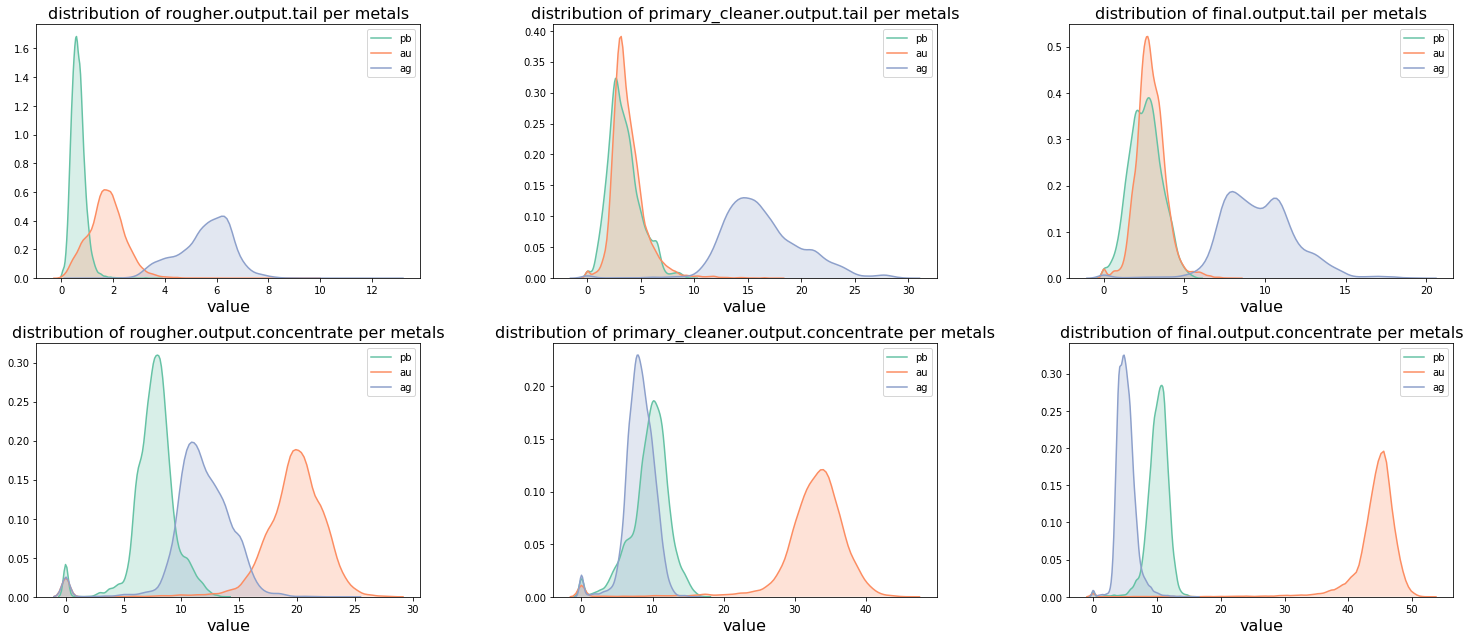

In [57]:
metals = ['au', 'ag', 'pb']
columns = ['rougher.output.tail', 'primary_cleaner.output.tail','final.output.tail',\
           'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

_, axs = plt.subplots(2,3, figsize=(21, 9))
axs = axs.flatten()

for column, ax in zip(columns, axs):
    cols = [f"{t}_{m}" for t,m in zip([column]*3,metals)]
    temp_df = pd.melt(df_train[cols])
    temp_df["variable"] = temp_df["variable"].str.replace(column+"_","")
    display_group_density_plot(temp_df, groupby="variable", on="value", title=f"distribution of {column} per metals", ax=ax)
    ax.legend()

plt.tight_layout()
plt.show()

we could see that there are some abnormal values of the concentration, especially in rougher and primary_cleaner stages. assume, that when first readouts had come about a concentration of the pb, ag, and on this stage we got some outliers around zero.   

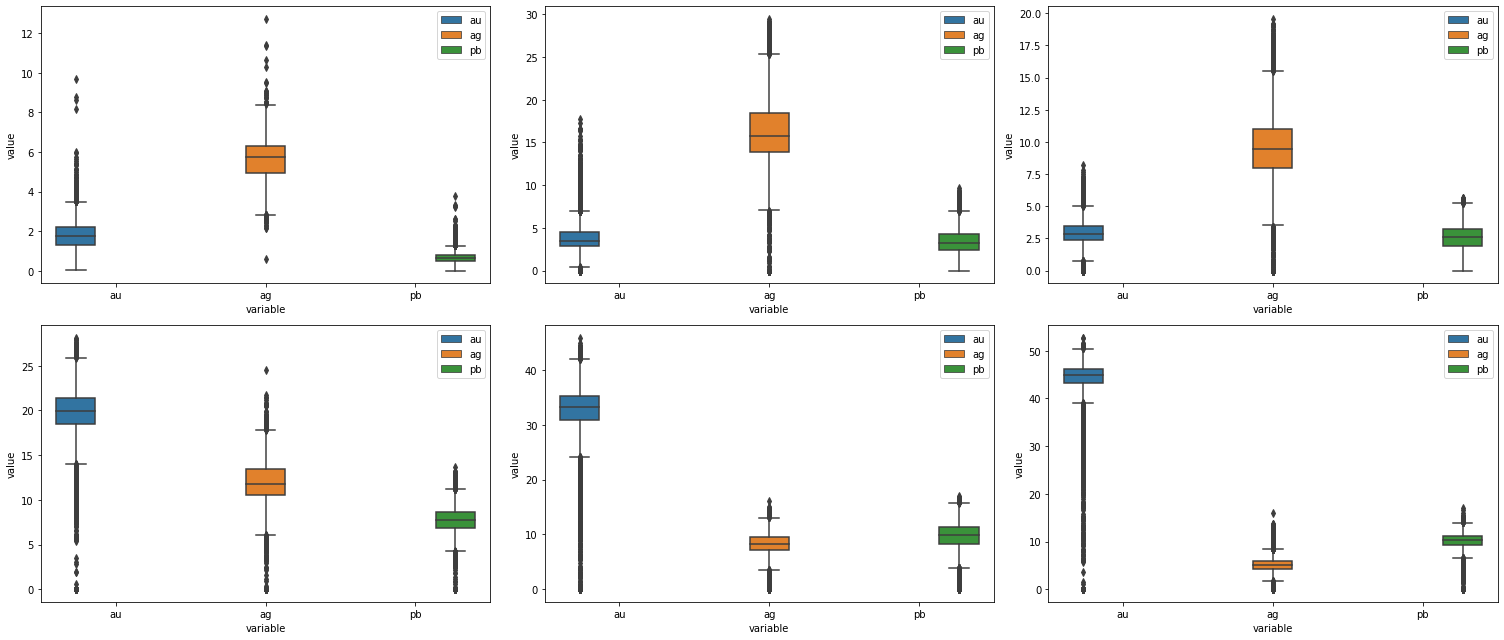

In [61]:
metals = ['au', 'ag', 'pb']
columns = ['rougher.output.tail', 'primary_cleaner.output.tail','final.output.tail',\
           'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

_, axs = plt.subplots(2,3, figsize=(21, 9))
axs = axs.flatten()

for column, ax in zip(columns, axs):
    cols = [f"{t}_{m}" for t,m in zip([column]*3,metals)]
    temp_df = pd.melt(df_train[cols])
    temp_df["variable"] = temp_df["variable"].str.replace(column+"_","")
    sns.boxplot(x="variable", y="value", hue="variable", data=temp_df, ax=ax)
    ax.legend()

plt.tight_layout()
plt.show()

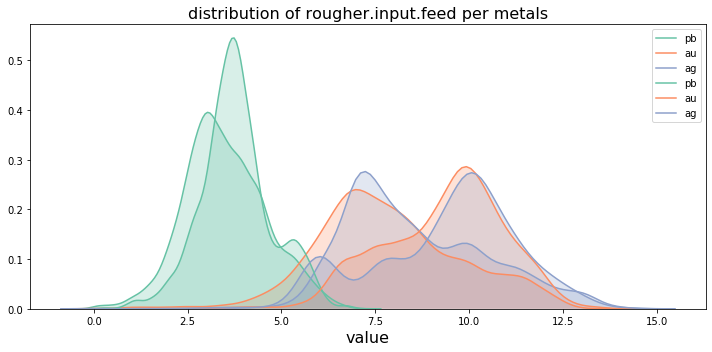

In [21]:
metals = ['au', 'ag', 'pb']
column = 'rougher.input.feed'
cols = [f"{t}_{m}" for t,m in zip([column]*3,metals)]
temp_df = pd.melt(df_train[cols])
temp_df["variable"] = temp_df["variable"].str.replace(column+"_","")
ax = display_group_density_plot(temp_df, groupby="variable", on="value", title=f"distribution of {column} per metals")
temp_df = pd.melt(df_test[cols])
temp_df["variable"] = temp_df["variable"].str.replace(column+"_","")
display_group_density_plot(temp_df, groupby="variable", on="value", title=f"distribution of {column} per metals", ax=ax)
plt.tight_layout()
plt.show()

In [29]:
list(filter(lambda s: "feed_size" in s, df_train.columns))

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

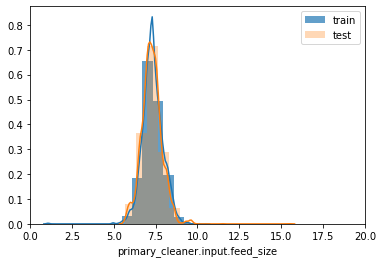

In [56]:
sns.distplot(df_train["primary_cleaner.input.feed_size"],bins=15, hist_kws=dict(alpha=0.7), label="train")
g = sns.distplot(df_test["primary_cleaner.input.feed_size"],bins=15, hist_kws=dict(alpha=0.3), label="test")
g.set(xlim=(0, 20))
g.legend()

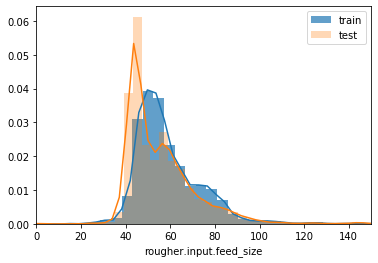

In [52]:
sns.distplot(df_train["rougher.input.feed_size"],bins=100, hist_kws=dict(alpha=0.7), label="train")
g = sns.distplot(df_test["rougher.input.feed_size"],bins=100, hist_kws=dict(alpha=0.3), label="test")
g.set(xlim=(0, 150))
g.legend()

In [27]:
df_train.describe()['rougher.input.feed_size']

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [22]:
df_test.describe()['rougher.input.feed_size']

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

#### Summary:

According to density plots the feed particle size distributions in the training set and in the test set is differenet, but I'd say so, it's not vary significantly, also we could see that mean values are really close to each other

as we could see, concentration of the gold was increased, but plumbum and silver after final stage were decreased or quite the same
(gold's concentration is increasing in a linear way. it's seems there is some chemistry property of the plumbum,  it's not changing so much in the final stage and silver's concetration is decreasing to a final stage)

<div class="alert alert-success">
    Great, you've studied the concentration changes, so we know that the process is doing what it's supposed to.
</div>

<div class="alert alert-danger">
    1. You seem to compare "input.feed" distributions instead of "input.feed_size" distributions. <br>
    2. Although you studied total concentrations, it seems that you missed the abnormal values near 0.
</div>

> * 1. it's true, it seems that I confused;) fixed it
  * I've noticed it, but didn't know how to explain, added explanation. also I think, that we need to leave this values for model, because it's better also to teach model on this abnormal values(on plots we could see that abnormal values near 0 are not just simple outliers)

3. Build the model

3.1. Write a function to calculate the final sMAPE value.

3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.
Use these formulas for evaluation metrics:

$sMAPE= \frac{1}{N} \sum_{i=1}^{N} \frac {|y_i-\hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2} \times 100\% $

$Final\hspace{0.2cm}sMAPE = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)$

In [23]:
target = ['rougher.output.recovery', 'final.output.recovery']
features = list(set(df_train.columns).intersection(set(df_test.columns)).difference(set(target)))

In [24]:
def smape(y_true, y_pred):
    frac = np.divide(np.abs(y_true - y_pred), (np.abs(y_true)+np.abs(y_pred))/2)
    return np.average(frac, axis=0)

In [25]:
def smape_final(y_true,y_pred):
    smape_out_rougher = smape(y_true[target.index('rougher.output.recovery')], y_pred[target.index('rougher.output.recovery')])
    smape_out_final = smape(y_true[target.index('final.output.recovery')], y_pred[target.index('final.output.recovery')])
    return 0.25*smape_out_rougher + 0.75*smape_out_final

<div class="alert alert-success">
    Metric calculation is absolutely correct!
</div>

In [36]:
print(df_train.isna().sum().sum())
print(df_test.isna().sum().sum())

0
0


In [27]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [41]:
smape_score = make_scorer(smape_final)

In [29]:
X_train, X_test = df_train[features].values, df_test[features].values
y_train, y_test = df_train[target].values, df_test[target].values

In [42]:
lr = LinearRegression().fit(X_train, y_train)
scores_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring=smape_score)
print("mean smape:", scores_lr.mean())
scores_lr

mean smape: 0.06141021786120819


array([0.03233747, 0.09156739, 0.09424053, 0.04954844, 0.03935726])

In [43]:
params = {'min_samples_split': range(2, 10, 2), 'max_depth': range(4,8,2)}
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=random_state),param_grid=params,scoring=smape_score, cv=5, refit=True)
g_cv.fit(X_train, y_train)
best_params = g_cv.best_params_

0.06413835818858496


In [44]:
dtr = DecisionTreeRegressor(**best_params).fit(X_train, y_train)
scores_dtr = cross_val_score(dtr, X_train, y_train, cv=5, scoring=smape_score)
print("mean smape:", scores_dtr.mean())
scores_dtr

mean smape: 0.06413835818858563


array([0.06771186, 0.15912833, 0.01024544, 0.06642316, 0.01718302])

In [ ]:
params = {'min_samples_split': range(2, 6, 2)}
rf_cv = GridSearchCV(RandomForestRegressor(random_state=random_state),param_grid=params,scoring=smape_score, cv=5, refit=True)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_

In [47]:
rfr = RandomForestRegressor(**best_params).fit(X_train, y_train)
scores_rfr = cross_val_score(rfr, X_train, y_train, cv=5, scoring=smape_score)
print("mean smape:", scores_rfr.mean())
scores_rfr

mean smape: 0.10870903856932972


array([0.21054431, 0.23147249, 0.00729214, 0.06787857, 0.02635768])

let's check with our baseline - DummyRegressor

In [48]:
dm = DummyRegressor(strategy='mean').fit(X_train, y_train)
y_pred = dm.predict(X_test)
print('smape:', smape_final(y_test, y_pred))

smape: 0.05430579681049148


#### Summary:

we compared several models with Dummy Regressor (sMAPE=0.054):

1) Linear regression: $sMAPE_{mean}\approx$0.0614

2) Decision tree regressor: $sMAPE_{mean}\approx$0.0614

3) Random forest regressor: $sMAPE_{mean}\approx$0.1087

Linear regression and Decision tree regressor have the best result according to the sMAPE

<div class="alert alert-info">
    The model training section is great: you try a few models, correctly use the train and test sets, use cross-validation, do some hyper-parameter tuning, and have a baseline. The only thing that is strange to me is that you say that linear regression and decision tree regressor have the best results, but don't say that they are both outperformed by a very dumb constant model predicting the mean of train set targets.
</div>

>that's true;) 

Project evaluation
* We’ve put together the evaluation criteria for the project. Read this carefully before moving on to the case.
* Here’s what the reviewers will look at when reviewing your project:
* Have you prepared and analyzed the data properly?
* What models have you developed?
* How did you check the model‘s quality?
* Have you followed all the steps of the instructions?
* Did you keep to the project structure and explain the steps performed?
* What are your findings?
* Have you kept the code neat and avoided code duplication?